In [1]:
#---------------------------------------------------------------------------------------------LIBRARIES--------------------------------------------------------------------------------------------                                                                                         #import OpenCV2 library for image processing and algorithms
import math
import csv 
import numpy as np                                                                                     #import numpy mathematical library
import pandas as pd
import pickle
import matplotlib.pyplot as plt      #import matplotlib library for plotting
from micromlgen import port

from IPython.core.display import display, HTML                                    
display(HTML("<style>.container { width:100% !important; }</style>"))                                  #change width of Jupyer Notebook to use the whole window resolution availab

# Fitting Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score

In [2]:
def plot_error(errors, y_pred, filename, name):
    plt.plot(errors)
    plt.xticks(ticks=[i for i in range(len(errors))], labels=y_pred)
    plt.xlabel('Predicted Value')
    plt.ylabel(name)
    plt.savefig(filename, dpi=500)                                                                                     #https://stackoverflow.com/questions/9622163/save-plot-to-image-file-instead-of-displaying-it-using-matplotlib
    plt.show()

def save_statistics(clf, X_test, y_true, csv_filename, mae_filename, mse_filename, metrics_filename):
    y_pred = []
    with open(csv_filename, "a", newline='') as fp:
        for row in X_test:
            result = float((str(clf.predict(row.reshape(1, -1))).replace('[','').replace(']','')))
            y_pred.append(result)
            wr = csv.writer(fp, dialect='excel')
            wr.writerow([result])
    fp.close()
    
    #https://machinelearningmastery.com/regression-metrics-for-machine-learning/
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html
    metrics = {"Mean Squared Error: " : mean_squared_error(y_true, y_pred),
               "Root Mean Squared Error: " : mean_squared_error(y_true, y_pred, squared=False), 
               "Mean Absolute Error: " : mean_absolute_error(y_true, y_pred),
               "Mean Deviation Error: " : str((abs((sum(y_true) / len(y_true))-(sum(y_pred) / len(y_pred))) / (sum(y_true) / len(y_true))))[1:-1],
               "R2 Score - Uniform Average: " : r2_score(y_true, y_pred), 
               "R2 Score - Variance Weighted: " : r2_score(y_true, y_pred, multioutput='variance_weighted')}
    
    # calculate errors
    mae_errors, mse_errors = [], []
    for i in range(len(y_true)):
        mae = abs((y_true[i] - y_pred[i]))               #calculate mean absolute error
        mse = (y_true[i] - y_pred[i])**2                 #calculate mean squared error
        mae_errors.append(mae)                           #store mea error
        mse_errors.append(mse)                           #store mse error
        
    #plot mean errors
    plot_error(mae_errors, y_pred, mae_filename, "Mean Absolute Error")
    plot_error(mse_errors, y_pred, mse_filename, "Mean Squared Error")
    
    with open(metrics_filename, 'w') as f:
        for k, v in metrics.items():
            f.write(str(k) + str(v) + '\n\n')
            print(str(k) + str(v))
    f.close()

Your Train Dataset is:  weather_data_2010_2020
Your Test Dataset is:  weather_data_2021_2022
Please choose 1 to display the dataset or any button to cotinue without displaying!2
Not displaying dataset!
Please choose 1 for Training and 2 for Random CV Search. 
                       Pressing 3 will load the optimised Random Forest Regressor model!3
Parameters Classifier Loaded:  {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 35, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 10, 'min_samples_split': 20, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


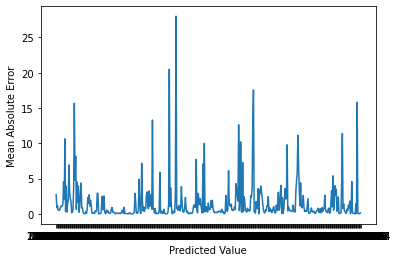

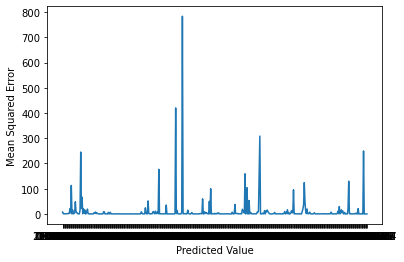

Mean Squared Error: 10.134111937259654
Root Mean Squared Error: 3.183411996154386
Mean Absolute Error: 1.4976764577262693
Mean Deviation Error: 0.11336021
R2 Score - Uniform Average: 0.260446593355525
R2 Score - Variance Weighted: 0.260446593355525


In [6]:
"""
Troining time:
- 20 years Humidity, Temperature, Pressure = 70 mins on a intel core i9 10900k (desktop)
- 2 years Humidity, Temperature, Pressure = 5 mins on a intel core i9 10900k (desktop)
- 2 years Humidity, Temperature, Pressure = 74 mins on a intel core i5 8250u (laptop)
"""

def main():
    #dataset selection and loading
    train_set_name = "weather_data_2010_2020"
    train_dataset = pd.read_csv(("./datasets/" + train_set_name + ".csv"),header=None)
    test_set_name = "weather_data_2021_2022"
    test_dataset = pd.read_csv(("./datasets/" + test_set_name + ".csv"),header=None) 

    print("Your Train Dataset is: ", train_set_name)                                                                       #display dataset name to user
    print("Your Test Dataset is: ", test_set_name)                                                                       #display dataset name to user

    features_selected = 6
    #training features
    temperature_train = train_dataset.iloc[:, 4:5]
    feels_like_train = train_dataset.iloc[:, 7:8]
    dew_point_train = train_dataset.iloc[:, 8:9]
    humidity_train = train_dataset.iloc[:, 9:10]
    pressure_train = train_dataset.iloc[:, 19:20] 
    uv_index_train = train_dataset.iloc[:, 24:25] 

    #testing data
    temperature_test = test_dataset.iloc[:, 4:5]
    feels_like_test = test_dataset.iloc[:, 7:8]
    dew_point_test = test_dataset.iloc[:, 8:9]
    humidity_true = test_dataset.iloc[:, 9:10]
    pressure_test = test_dataset.iloc[:, 19:20]
    uv_index_test = test_dataset.iloc[:, 24:25] 

    X_train = pd.concat([temperature_train, feels_like_train, dew_point_train, humidity_train, pressure_train, uv_index_train], axis=1)
    X_train.replace(([np.inf, -np.inf], np.nan), inplace=True)                                                            #replace any infinite values with nan
    X_train = X_train.to_numpy()  


    y_train = train_dataset.iloc[:, 10:11].to_numpy()
    y_true = test_dataset.iloc[:, 10:11].to_numpy()

    #https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
    test_data = pd.concat([temperature_test, feels_like_test, dew_point_test, humidity_true, pressure_test, uv_index_test], axis=1)       
    test_data.replace(([np.inf, -np.inf], np.nan), inplace=True)                                                            #replace any infinite values with nan
    X_test = test_data.to_numpy()

    #change all nan values in all datasets with the most frequent value of the dataset
    imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    imp.fit(X_train)
    imp.fit(y_train)
    imp.fit(X_test)
    imp.fit(y_true)

    disp = int(input("Please choose 1 to display the dataset or any button to cotinue without displaying!"))
    if disp == 1:
        display(X_train)
        display(y_train.ravel())

        display(X_test)
    else: print("Not displaying dataset!")   

    #------------------------------------------------------------------------------------------
    choice = int(input("""Please choose 1 for Training and 2 for Random CV Search. 
                       Pressing 3 will load the optimised Random Forest Regressor model!"""))
    clf_type = "default" if choice == 1 else "optimised"
    model_name = "./trained_models/rfr_optimised_" + train_set_name + "_" + test_set_name + "_" + str(features_selected) + "f.p"
    mae_filename = "./plots/rfr_mae" + str(clf_type) + "_" + train_set_name + "_"  + test_set_name + "_" + str(features_selected) + "f.png"
    mse_filename = "./plots/rfr_mse" + str(clf_type) + "_" + train_set_name + "_"  + test_set_name + "_" + str(features_selected) + "f.png"
    metrics_filename = "./metrics/rfr_" + str(clf_type) + "_" + train_set_name + "_"  + test_set_name + "_" + str(features_selected) + "f.txt"
    csv_filename = "./outputs/output_rfr_"  + str(clf_type) + "_" + train_set_name + "_"  + test_set_name + "_" + str(features_selected) + "f.csv"

    if choice == 1:
        # Create Random Forest classifer object and train it on the selected dataset
        rfr = (RandomForestRegressor()).fit(X_train, y_train.ravel()) 
        save_statistics(rfr, X_test, y_true, csv_filename, mae_filename, mse_filename, metrics_filename)

    elif choice == 2:
        print("You've chosen Random Random+Grid Search Optimisation for the Random Forest Regressor")

        rfr = RandomForestRegressor()
        param_random = { 
            'n_estimators': [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt', 'log2'],
            'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 
            'bootstrap': [True, False]}

        rfr_random_search = RandomizedSearchCV(estimator = rfr, param_distributions = param_random, 
                                               n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1, scoring='r2', refit = True)
        rfr_random_search.fit(X_train, y_train.ravel())
        best_random_search = list(rfr_random_search.best_params_.values())
        print(rfr_random_search.best_params_)

        param_grid = { 
            'n_estimators': [int(best_random_search[0]-100), int(best_random_search[0]-50), int(best_random_search[0]-25), int(best_random_search[0]),
                                                        int(best_random_search[0]+25), int(best_random_search[0])+50, int(best_random_search[0])+100],
            'min_samples_split': [int(best_random_search[1]/3), int(best_random_search[1]/2), int(best_random_search[1]), 
                                                             int(best_random_search[1]*2), int(best_random_search[1]*3)],
            'min_samples_leaf': [best_random_search[2]-1, best_random_search[1], best_random_search[1]+1],
            'max_features': ['auto', 'sqrt', 'log2'],
            'max_depth': [best_random_search[4]-5, best_random_search[4], best_random_search[4]+5],
            'bootstrap': [best_random_search[5]]}

        rfr_grid_search = GridSearchCV(estimator = rfr, param_grid = param_grid, cv = 5, n_jobs = -1,
                                                             verbose = 2, scoring='r2', refit = True)
        rfr_grid_search.fit(X_train, y_train.ravel())
        best_grid_search = list(rfr_grid_search.best_params_.values())
        print(rfr_grid_search.best_params_)
        print(rfr_grid_search.best_estimator_)

        pickle.dump(rfr_grid_search.best_estimator_, open(model_name, "wb"))

    elif choice == 3:
        rfr = pickle.load(open(model_name, "rb"))
        print("Parameters Classifier Loaded: ", rfr.get_params())

        save_statistics(rfr, X_test, y_true, csv_filename, mae_filename, mse_filename, metrics_filename)

if __name__ == "__main__":                                                                                               #guard boilerplate
    main()